In [1]:
import numpy as np
import scipy.spatial
import matplotlib.pyplot as plt 
import random 
import math
import cmath
#from scipy.misc import derivative
import sympy

# Solution 1


In [2]:

def get_cov(f, points1, points2):
    """Return covariance matrix for the sets of points given according to covariance function f"""
    size1 = points1.shape[0]
    size2 = points2.shape[0]
    cov = np.empty((size1, size2)) 
    for i in range(size1):
        for j in range(size2):
            cov[i, j] = f(points1[i], points2[j])
    return cov  

In [3]:
# examples of covariance functions 

def K_Linear(s,t):
    return abs(s-t)

def Sinc(s, t):
    return np.sinc(s-t)

def K_Wiener(s, t):
    return min(s, t)

def K_RBF(s, t):
    return np.exp(-0.5 * abs(s-t)**2)

def K_brownian_bridge(s, t):
    return min(s, t) - s*t

def exponential(s, t):
    return np.exp(-abs(s-t))

def wave(s,t):
    return np.cos(s-t)

a = np.linspace(2, 5, 4)
b = np.linspace(4, 7, 5)
print(a)
print(b)
get_cov(wave, a, b)


[2. 3. 4. 5.]
[4.   4.75 5.5  6.25 7.  ]


array([[-0.41614684, -0.92430238, -0.93645669, -0.44608749,  0.28366219],
       [ 0.54030231, -0.17824606, -0.80114362, -0.99412968, -0.65364362],
       [ 1.        ,  0.73168887,  0.0707372 , -0.62817362, -0.9899925 ],
       [ 0.54030231,  0.96891242,  0.87758256,  0.31532236, -0.41614684]])

In [4]:
Sinc(4, 4)

1.0

In [5]:
# examples of mean functions 
def square(s):
    return s*s

def linear(s):
    return s

def zero(s):
    return 0

In [6]:
def simulate_GP(mean_function, cov_function, nb_of_samples, number_of_functions, left_border, right_border, ls = True):
    points = np.linspace(left_border, right_border, nb_of_samples)
    Σ = get_cov(cov_function, points, points)
    mean_vals = [mean_function(point) for point in points]
    ys = np.random.multivariate_normal(
                                       mean_vals,
                                       cov=Σ,
                                       size=number_of_functions)
    fig = plt.figure(figsize=(12, 6), dpi=80)
    
    for i in range(number_of_functions):
        if ls:
            plt.plot(points, ys[i])
            plt.plot(points, np.zeros_like(points), color = 'green') 
        #else:
        #    plt.plot(points, ys[i], ls = 'None')
        #plt.scatter(points, ys[i])      
    return ys, fig

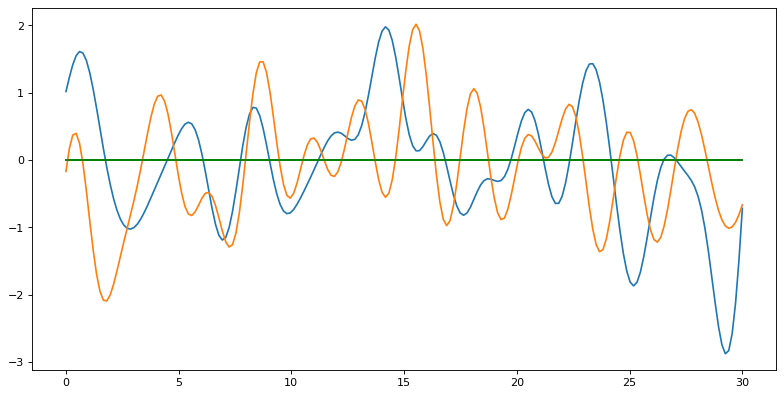

In [7]:
a = simulate_GP(zero, Sinc, 200, 2, 0, 30)

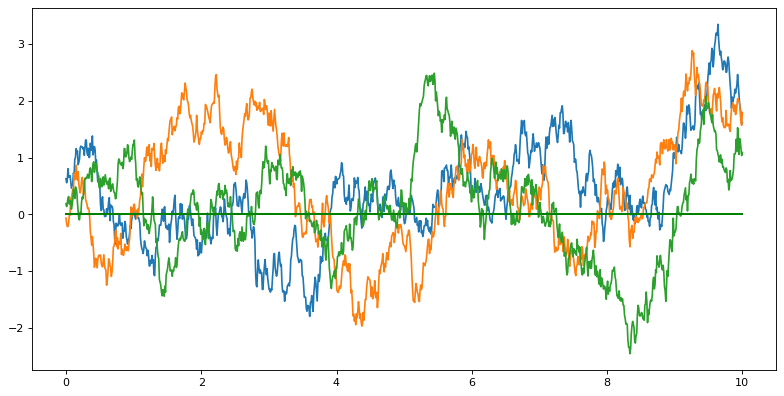

In [8]:
a = simulate_GP(zero, exponential, 1000, 3, 0, 10)

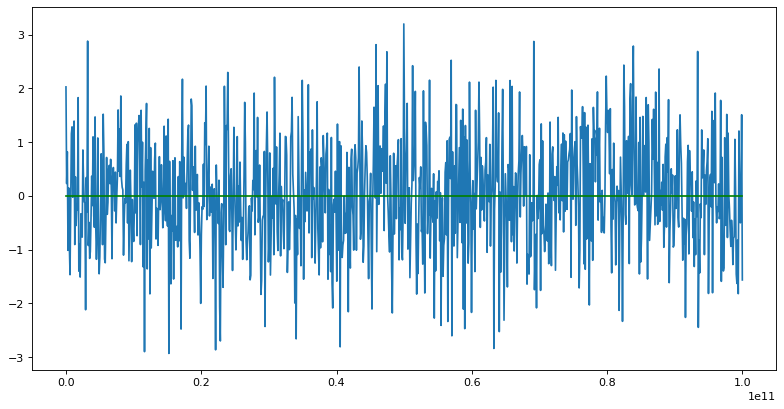

In [9]:
a = simulate_GP(zero, Sinc, 1000, 1, 0, 100000000000)

The more samples, the bigger time of work. Not depending on a kernel chosen. However, when covariance matrix is small enough (less or equal to 1000x1000), algorythm works fast even on big time intervals.

In [10]:
def prime(f,x):
    e = 10e-8
    return (f(x+e) - f(x-e) )/(2*e)
   
def prime_prime(f, x):
    e = 10e-4
    return ( f(x+e) - 2*f(x) + f(x-e) )/e/e

In [11]:
def cube(x):
    return x*x*x

prime_prime(cube, 3)

18.000000000739647

In [12]:
def E(cov_function):
    r = lambda x: cov_function(0, x) # covariance function 
    
    deriv = -prime_prime(r, 0) # minus second derivative
    alfa = np.sqrt(deriv/(r(0)+10e-8))
    E_zeros = 1/np.pi * alfa # count average amount of zeroes using Kac-Rice formula
        
    return E_zeros    

In [16]:
# comparison function
def cmp(a, b): 
    if a > b:
        return 1
    elif a < b:
        return -1
    else:
        return 0


def intersections(mean_function, cov_function, nb_of_samples, number_of_functions, left_border, right_border, ls = True):
    zeros = np.zeros(number_of_functions) # будущее кол-во нулей по всем функциям 
    Y, _ = simulate_GP(mean_function, cov_function, nb_of_samples, number_of_functions, left_border, right_border, ls)
    size = Y.shape[1]
    
    # считаю кол-во нулей
    for j in range(number_of_functions): # если 2 соседних значения разных знаков, то между ними ноль
        pairs = [(Y[j][i], Y[j][i+1]) for i in range(size - 1)]  # буду проверять каждую пару значений 
        for (a,b) in pairs:
            if cmp(a, 0) != cmp(b, 0):
                zeros[j] += 1
    
    E_zeros = E(cov_function) * (right_border - left_border) # считаю среднее число нулей по формуле
    
    # и округляю до ближайшего целого 
    if np.ceil(E_zeros) - E_zeros > E_zeros - np.floor(E_zeros): 
        E_zeros = np.floor(E_zeros)
    else:
        E_zeros = np.ceil(E_zeros)
    
    plt.figure(figsize = (10, 5), dpi=80)
    plt.hist(zeros, edgecolor='white')
    print('E_zeros:',E_zeros)
    return zeros, E_zeros  

E_zeros: 17.0


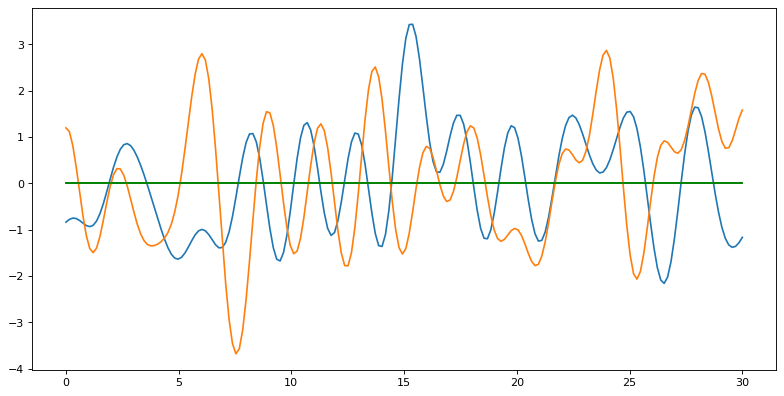

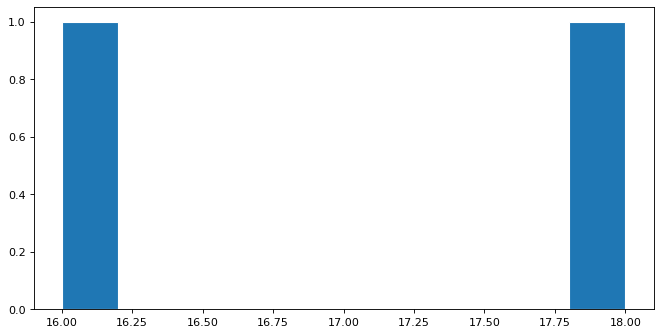

In [17]:
a = intersections(zero, Sinc, 200, 2, 0, 30)

E_zeros: 17.0


<Figure size 960x480 with 0 Axes>

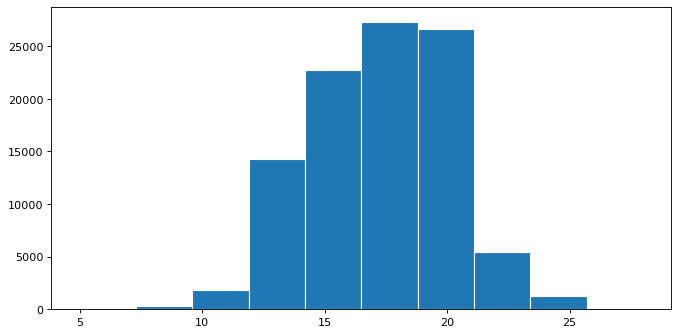

In [18]:
a = intersections(zero, Sinc, 200, 100000, 0, 30, ls=False)

E_zeros: 58.0


<Figure size 960x480 with 0 Axes>

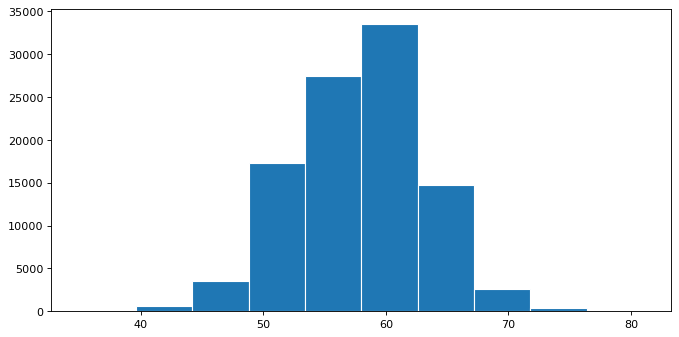

In [19]:
a = intersections(zero, Sinc, 1000, 100000, 0, 100, ls=False)

E_zeros: 577.0


<Figure size 960x480 with 0 Axes>

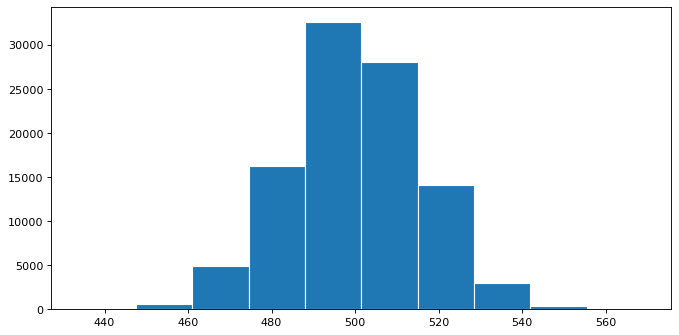

In [20]:
a = intersections(zero, Sinc, 1000, 100000, 0, 1000, ls=False)

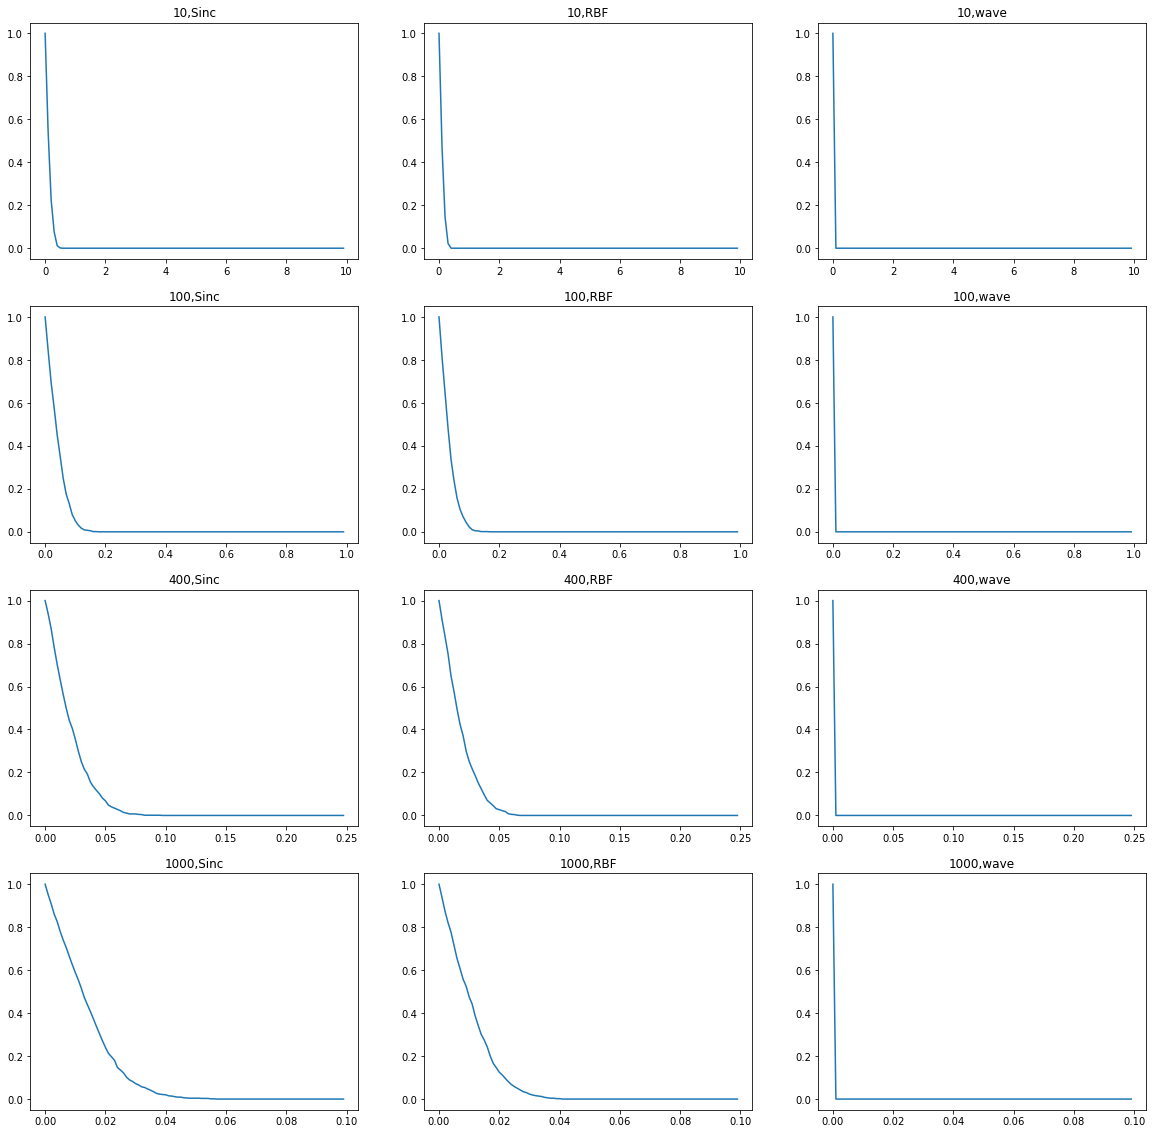

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

In [22]:
# Здесь хочу выводить данные  в следующем виде:
# на каждой картинке график P(кол-во нулей / T > E(T=1) + e) в зависимости от эпсилон. 
# В одной строке графики для фиксированного временного интервала T и разных ковариаций. Разные строчки для разных значений T.

T = [10, 100, 400, 1000] #временные интервалы
kernel = [Sinc, K_RBF, wave] # ковариации
kernel_names = ["Sinc", "RBF", "wave"]

fig, axs = plt.subplots(4, 3, figsize=(20, 20))
for i in range(len(T)):
    eps = [n/T[i] for n in range(100)] 
    for j in range(len(kernel)):
        P = np.zeros(len(eps))
        zeros, _ = intersections(zero, kernel[j], T[i]*5, 1000, 0, T[i], ls = False) 
        for idx,e in enumerate(eps):
            cnt = 0
            for k in range(len(zeros)):
                if abs(zeros[k]/T[i] - E(kernel[j])) > e:
                    P[idx] += 1            
        P = P/1000
        axs[i, j].plot(eps, P)
        axs[i, j].set_title(f'{T[i]},{kernel_names[j]}')

<ipython-input-7-cc1bcf3c7725>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 6), dpi=80)


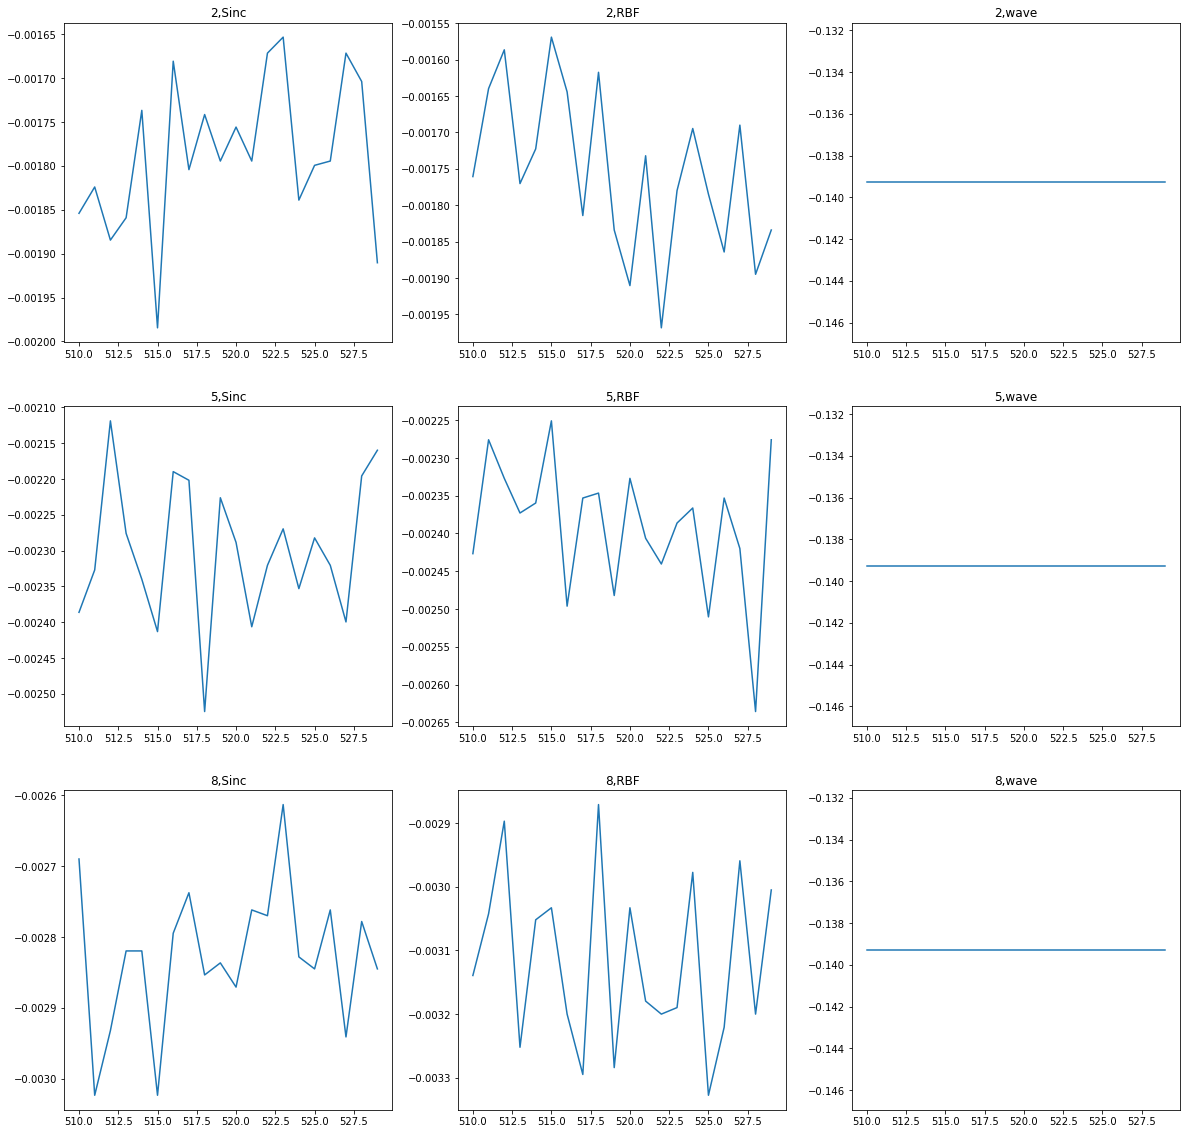

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

In [49]:
plt.close('all')

Eps = [2, 5, 8]#, 0.1] # epsilon
kernel = [Sinc, K_RBF, wave] # covariance functions
kernel_names = ["Sinc", "RBF", "wave"]
T = [n for n in range(510, 530)] # time intervals 

fig, axs = plt.subplots(len(Eps), len(kernel), figsize=(20, 20))
for i in range(len(Eps)):
    for j in range(len(kernel)):
        P = np.zeros(len(T))
        for idx, t in enumerate(T):
            zeros, _ = intersections(zero, kernel[j], t*5, 1000, 0, t, ls = False) 
            cnt = 0
            for k in range(len(zeros)):
                if zeros[k]/t - E(kernel[j]) > Eps[i]/t:
                    P[idx] += 1
        P += 10e-30            
        P = np.log(P/1000)
        axs[i, j].plot(T, P/t)
        axs[i, j].set_title(f'{Eps[i]},{kernel_names[j]}')

# Solution 1.5

In [21]:
# Gaussian process posterior
def Gaussian_Posterior(X1, y1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    N = X1.shape[0]
    add = np.eye(N)
    Σ11 = get_cov(kernel_func, X1, X1) + add*10e-8
    # Kernel of observations vs to-predict
    Σ12 = get_cov(kernel_func, X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = get_cov(kernel_func, X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

In [24]:
def Posterior3(mean_function, cov_function, nb_of_samples, number_of_functions, left_border, right_border, iterations, ls = True):
    """Create number_of_samples gaussian values on interval
       [left_border, right_border]
       according to prior distribution of the previous
       values, generated by means of Simulate_GP. """
    
    len_interval = (right_border - left_border) / (iterations+1)
    delta = len_interval/(nb_of_samples - 1)

    final_y = np.zeros((number_of_functions, (iterations+1)*nb_of_samples))
    # create initial values using solution 1
    X1 = np.linspace(left_border, left_border+len_interval, nb_of_samples)
    y1, fig = simulate_GP(mean_function, 
                          cov_function,
                          nb_of_samples,
                          number_of_functions,
                          left_border,
                          left_border+len_interval,
                          ls = False)
    
    for func in range(number_of_functions): 
        y = np.zeros((iterations+1, nb_of_samples))
        X = np.zeros((iterations+1, nb_of_samples))
        y[0,:] = y1[func]
        X[0,:] = X1
        for it in range(1, iterations+1):
            X2 = np.linspace(left_border + len_interval*it, left_border + len_interval*(it+1), nb_of_samples)
            #compute posterior distribution 
            μ2, Σ2 = Gaussian_Posterior(X[it-1,:], y[it-1,:], X2, cov_function)
            #generate new samples
            y[it, :] = np.random.multivariate_normal(μ2, cov=Σ2)
            X[it, :] = X2
            
        X = np.reshape(X,((iterations+1)*nb_of_samples,))  
        final_y[func] = np.reshape(y,((iterations+1)*nb_of_samples,))
        if ls:       
            plt.plot(X, final_y[func], figure = fig)
            plt.plot(X, np.zeros_like(X), color = 'green')     
         
    if ls:
        plt.show() 
    return final_y, fig  

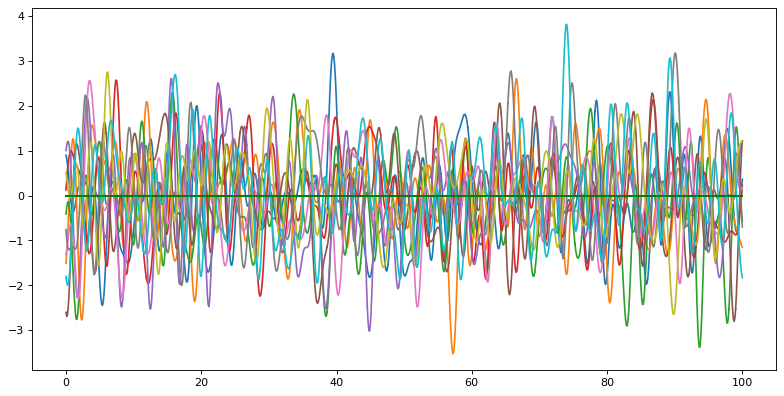

In [25]:
a = Posterior3(zero, Sinc, 10, 10, 0, 100, 100)

In [112]:
def post_intersections(mean_function, cov_function, nb_of_samples, number_of_functions, left_border, right_border, iterations, ls = True, y = False):
    zeros = np.zeros(number_of_functions) # future amount of zeros for all functions  
    Y, _ = Posterior3(mean_function,
                      cov_function,
                      nb_of_samples,
                      number_of_functions,
                      left_border,
                      right_border,
                      iterations,
                      ls)
    size = Y.shape[1]
    
    # count amount of zeros
    for j in range(number_of_functions): # if two neighbouring values are of different signs, then there's a zero between them
        pairs = [(Y[j][i], Y[j][i+1]) for i in range(size - 1)]  # check every pair of neighbouring values 
        for (a,b) in pairs:
            if cmp(a, 0) != cmp(b, 0): # compare two values
                zeros[j] += 1
    
    E_zeros = E(cov_function) * (right_border - left_border) # count average amount of zeroes using Kac-Rice formula
    
    # round to nearest integer 
    if np.ceil(E_zeros) - E_zeros > E_zeros - np.floor(E_zeros): 
        E_zeros = np.floor(E_zeros)
    else:
        E_zeros = np.ceil(E_zeros)
    if ls: 
        plt.figure(figsize = (10, 5), dpi=80)
        plt.hist(zeros, edgecolor='white')
        print('E_zeros:',E_zeros)
    if y: 
        return zeros, E_zeros, Y
    else:
        return zeros, E_zeros

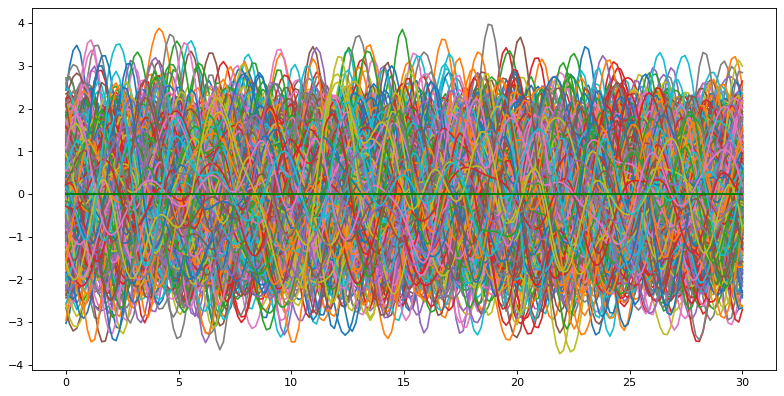

E_zeros: 17.0


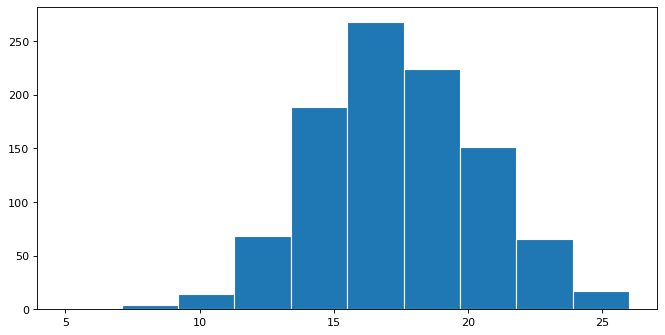

In [113]:
a = post_intersections(zero, Sinc, 10, 1000, 0, 30, 20, ls = True)

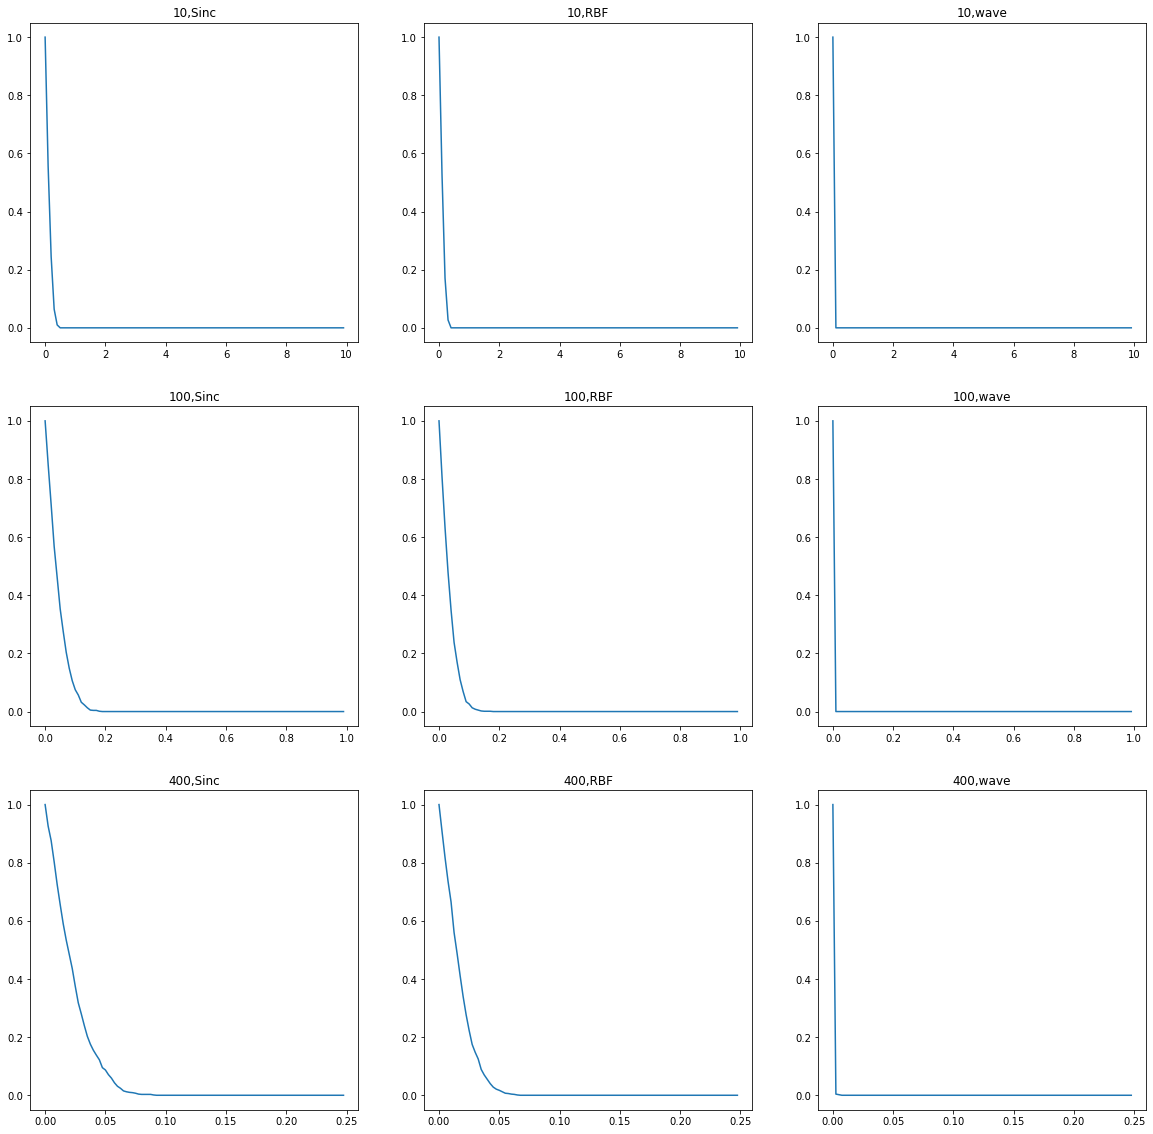

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

In [34]:
T = [10, 100, 400]#, 1000] #временные интервалы
kernel = [Sinc, K_RBF, wave] # ковариации
kernel_names = ["Sinc", "RBF", "wave"]

fig, axs = plt.subplots(len(T), len(kernel), figsize=(20, 20))
for i in range(len(T)):
    eps = [n/T[i] for n in range(100)] 
    for j in range(len(kernel)):
        P = np.zeros(len(eps))
        zeros, _ = post_intersections(zero, kernel[j], 20, 1000, 0, T[i], int(T[i]/2), ls = False) 
        for idx,e in enumerate(eps):
            cnt = 0
            for k in range(len(zeros)):
                if abs(zeros[k]/T[i] - E(kernel[j])) > e:
                    P[idx] += 1            
        P = P/1000
        axs[i, j].plot(eps, P)
        axs[i, j].set_title(f'{T[i]},{kernel_names[j]}')

<ipython-input-6-cc1bcf3c7725>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 6), dpi=80)


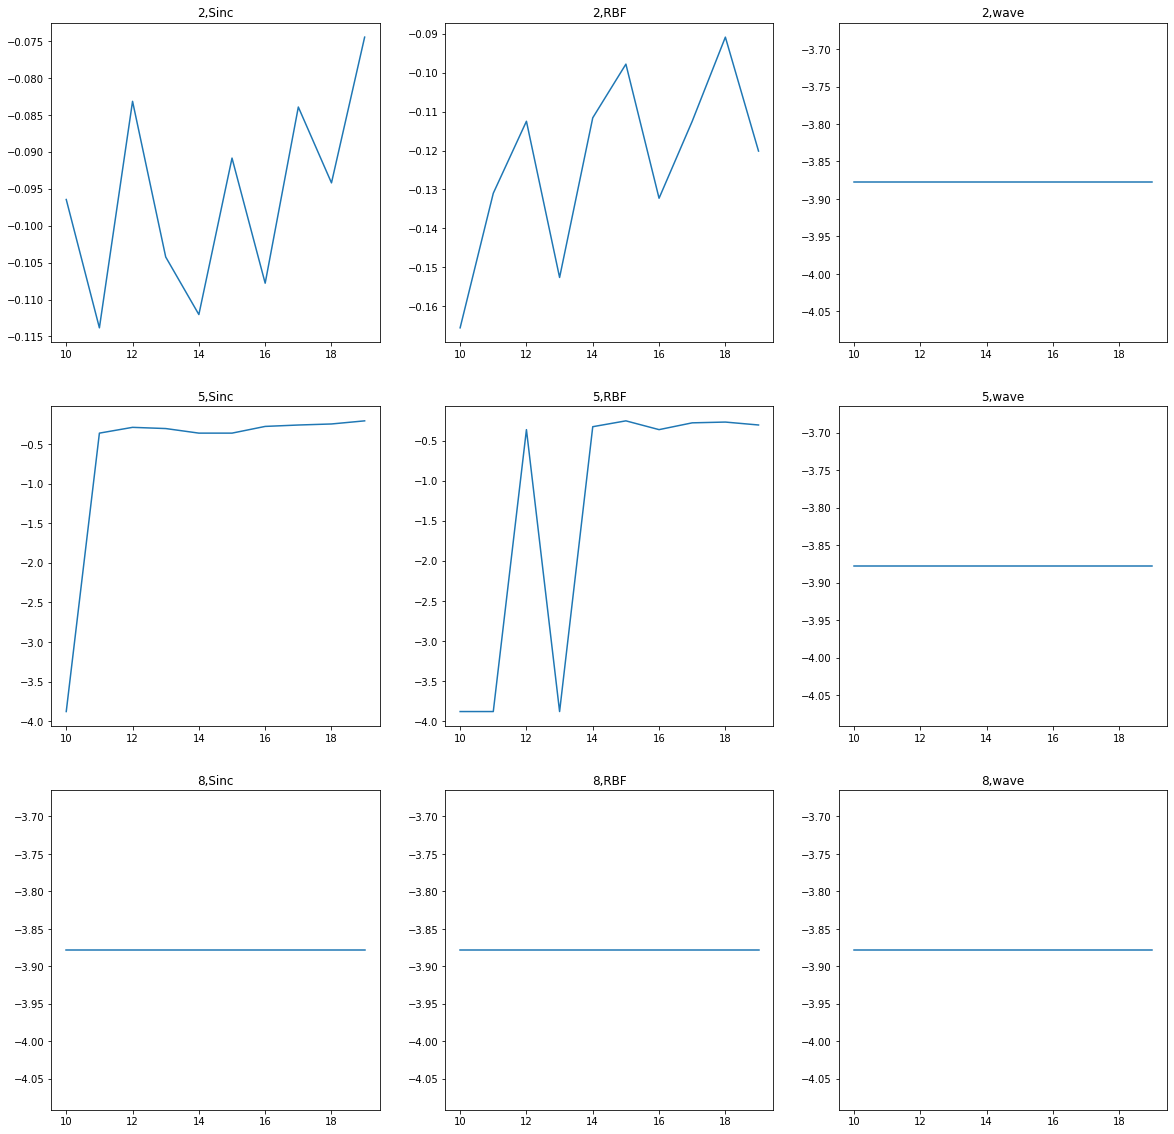

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

In [28]:
plt.close('all')

Eps = [2, 5, 8]#, 0.1] # epsilon
kernel = [Sinc, K_RBF, wave] # covariance functions
kernel_names = ["Sinc", "RBF", "wave"]
T = [n for n in range(10, 20)] # time intervals 

fig, axs = plt.subplots(len(Eps), len(kernel), figsize=(20, 20))
for i in range(len(Eps)):
    for j in range(len(kernel)):
        P = np.zeros(len(T))
        for idx, t in enumerate(T):
            zeros, _ = post_intersections(zero, kernel[j], 30, 1000, 0, t, int(t/3), ls = False) 
            cnt = 0
            for k in range(len(zeros)):
                if zeros[k]/t - E(kernel[j]) > Eps[i]/t:
                    P[idx] += 1
        P += 10e-30            
        P = np.log(P/1000)
        axs[i, j].plot(T, P/t)
        axs[i, j].set_title(f'{Eps[i]},{kernel_names[j]}')

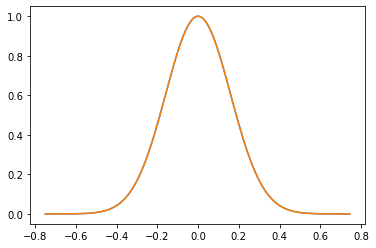

In [114]:
kernel = K_RBF # covariance functions
r = lambda x: kernel(0, x)
N = 300
A = 100
X = np.linspace(-A, A, N+1)[:-1]
delta = X[1]-X[0] # = 2*A/N - time step
F = 1./delta      # = N/(2*A) - sampling frequency
w = np.linspace(-F/2, F/2, N+1)[:-1]   # FFT frequencies
K = [r(2*np.pi*x) for x in w]          # Fourier transform of a kernel in 2pi*w points

k = [r(x) for x in X]                  # kernel time points
density = np.fft.fft(k)
density = [np.real(x) for x in density]
size = N
density = np.hstack((density[size//2:], density[:size//2]))
density *= 2*A/N/np.sqrt(2*np.pi)

plt.plot(w, np.abs(density))
plt.plot(w, K)




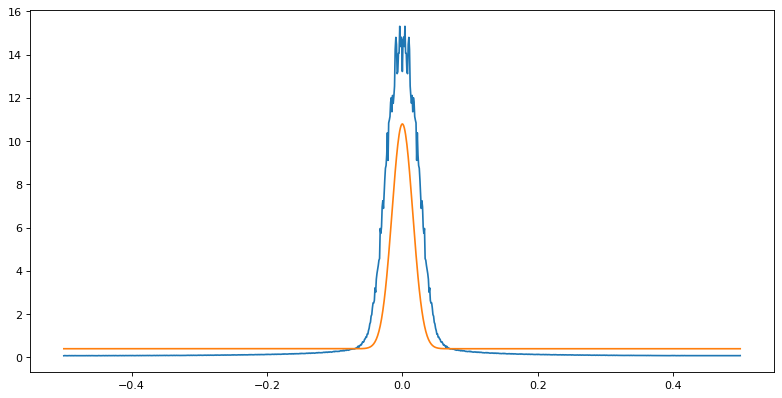

In [148]:
kernel = K_RBF # covariance functions
r = lambda x: kernel(0, x)

Eps = [0.01]#, 0.05, 0.08, 0.15] # epsilon
T = [100]#, 1000, 5000, 10000] # time intervals 

#fig, axs = plt.subplots(len(Eps), len(T), figsize=(20, 20))

for i, e in enumerate(Eps):
    for j, t in enumerate(T): 
        zeros, E_zeros, Y = post_intersections(zero, kernel, 40, 200, 0, t, t//4, ls = False, y = True)
        undercrowding = np.zeros(Y.shape[1])
        Q = np.fft.fft(undercrowding)
        Q = np.array([np.real(q) for q in Q])
        size = Q.shape[0]
        N = [i/size for i in range(-size//2, size//2)]
        count = 0
        Q_ =  np.fft.fft(Y[0])
        Q_ = np.array([np.real(q)**2 + np.imag(q)**2 for q in Q_])
        Q_ /= np.sqrt(size*2*np.pi)
        Q_ = np.sqrt(Q_)
        Q_ = np.hstack((Q_[size//2:], Q_[:size//2]))
        for z in range(len(zeros)):
            if E_zeros - zeros[z] < -e*t:
                Q0 =  np.fft.fft(Y[z])
                Q0 = np.array([np.real(q)**2 + np.imag(q)**2 for q in Q0])
                Q0 /= np.sqrt(size*2*np.pi)
                Q += np.sqrt(Q0)
                count += 1
        Q /= count + 1e-30
        Q = np.hstack((Q[size//2:], Q[:size//2]))
        almost_density = Q
        X = np.linspace(0, t, size+1)[:-1]
        k = [r(x) for x in X]                  # kernel time points
        true_density = np.fft.fft(k)
        true_density = [np.real(x) for x in true_density]
        true_density = np.hstack((true_density[size//2:], true_density[:size//2]))
        true_density *= 2/np.sqrt(2*np.pi)
        
        #axs[i, j].plot(N, almost_density)
        #axs[i, j].plot(N, true_density)
        #axs[i, j].set_title(f'Eps = {e},T = {t}') 
        
        #N_ = [n/np.sqrt(2*np.pi) for n in N]
        plt.plot(N, almost_density)
        plt.plot(N,  true_density)
        #plt.plot(N, Q_)

-3.8981718325193755e-17